# Segmentação de Clientes

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df = pd.read_csv("data/CC GENERAL.csv")
df.drop('CUST_ID', axis=1, inplace=True)

# Tratamento de nulos
imputer = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

# Normalização
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed),columns=df.columns)

print(df_scaled.head())

    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2                    2.673451      

### ETAPA 2  ANÁLISE EXPLORATÓRIA

Nessa etapa o objetivo é descobrir quantos grupos (cluster) existem matematicamente nos dados utilizados.
O "Método do Cotovelo" introduzido durantes as aulas foi usado para estimar esse valor.

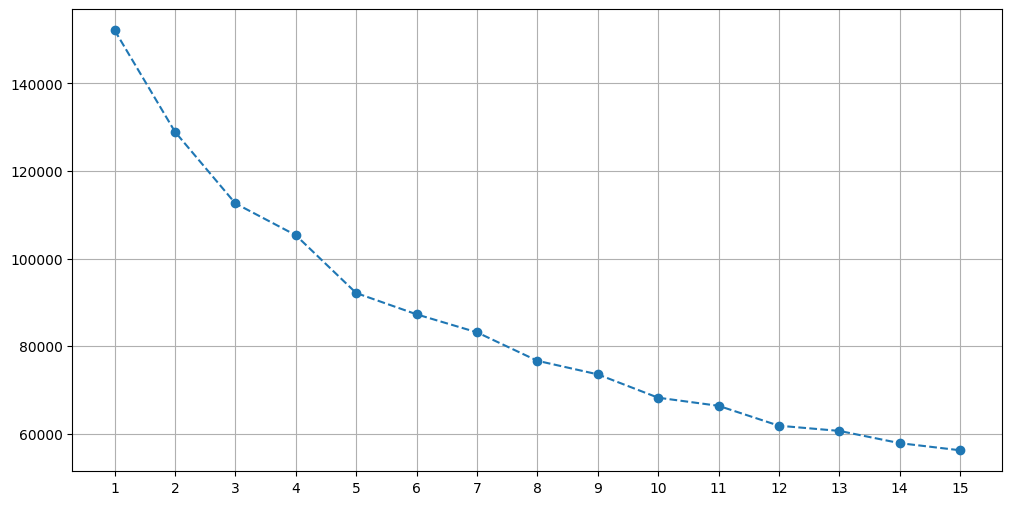

In [22]:
from sklearn.cluster import KMeans

wcss = []
k_range = range(1,16)
for i in k_range:
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Gráfico de cotovelo para visualização do número de clusters.

plt.figure(figsize=(12,6))
plt.plot(k_range, wcss, marker = 'o', linestyle='--')
plt.title = 'Método do cotovelo '
plt.xlabel = "Nº de clusters"
plt.xticks(k_range)
plt.ylabel = "Inércia"
plt.grid(True)
plt.show()    

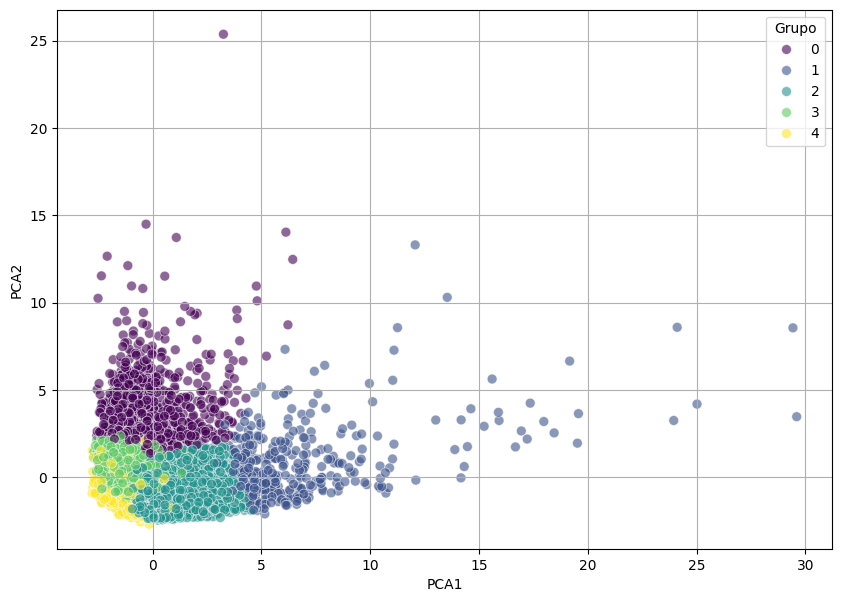

In [23]:
from sklearn.decomposition import PCA

# 1. Aplicar o K-Means Definitivo (K=5)
kmeans_final = KMeans(n_clusters= 5, init='k-means++', random_state=42)
clusters = kmeans_final.fit_predict(df_scaled)

# Adicionar a informação do cluster de volta ao DataFrame ORIGINAL (para analisarmos depois)
df['CLUSTER'] = clusters

# 2. Redução de Dimensionalidade (PCA) para Visualização 2D

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Criar um DataFrame temporário só para o gráfico
df_pca = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
df_pca['CLUSTER'] = clusters

# 3. Plotar o Gráfico Final
plt.figure(figsize=(10,7))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', data=df_pca, palette='viridis', s=50, alpha=0.6)
plt.title = "Segmentação de Clientes (K-Means e= PCA)"
plt.xlabel = 'Componente Principal 1 (Maior Variância)'
plt.ylabel = 'Componente Principal 2 (Segunda Maior Variância)'
plt.legend(title='Grupo')
plt.grid(True)
plt.show()

In [24]:
perfil_clusters = df.groupby('CLUSTER').mean()

# Colunas mais importantes do dataset.
colunas_chave = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']
print(perfil_clusters[colunas_chave])

print("\nContagem de Clientes por Grupo:")
print(df['CLUSTER'].value_counts())

             BALANCE    PURCHASES  CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS
CLUSTER                                                                   
0        4903.428600   553.101884   4983.093638   8062.618587  3858.809663
1        3588.990384  7815.732886    661.788641   9769.620253  7409.095001
2         930.357741  1299.705338    226.754889   4272.477078  1388.751132
3        1526.118239   255.461815    794.776687   3244.229297   958.642822
4         111.260364   335.222822    325.747598   3687.860947  1076.939244

Contagem de Clientes por Grupo:
CLUSTER
2    3164
3    3047
4    1357
0     987
1     395
Name: count, dtype: int64



*   GRUPO 3 E 4: MASSA ⇒ Tudo muito baixo 
*   GRUPO 1: DISPERSÃO HORIZONTAL ⇒ Maior `PURCHASES` e `CREDIT_LIMIT`
*   GRUPO 0: DISPERSÃO VERTICAL ⇒ `CASH ADVANCE` alto demais = tomadores de empréstimo
*   GRUPO 2: TRANSIÇÃO